# Importing useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


# Load and show the Dataset

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


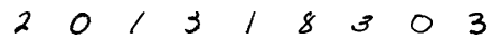

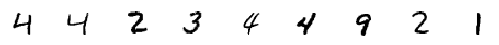

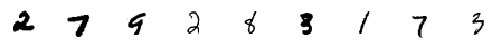

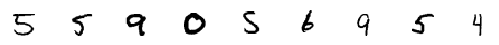

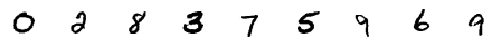

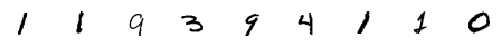

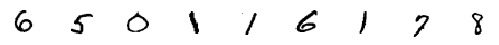

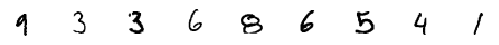

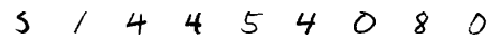

In [3]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))


for k in range(9):
    plt.figure(figsize=(9,6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainy[i])
    plt.show()

# Prepare data for the model

In [4]:
trainX = np.where(trainX < (0.33 * 256), 0, 1)
train_data = trainX.astype(np.float32)

testX = np.where(testX < (0.33 * 256), 0, 1)
test_data = testX.astype(np.float32)

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# Define Custom Masked CNN layeys for Pixel CNN

### Following snippet is taken from : https://keras.io/examples/generative/pixelcnn/

In [5]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.

import tensorflow

class PixelConvLayer(tensorflow.keras.layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = tensorflow.keras.layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)


# Next, we build our residual block layer.
# This is just a normal residual block, but based on the PixelConvLayer.
class ResidualBlock(tensorflow.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = tensorflow.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )
        self.pixel_conv = PixelConvLayer(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = tensorflow.keras.layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return tensorflow.keras.layers.add([inputs, x])

# Define Pixel-CNN    

In [6]:
inputs = tensorflow.keras.Input(shape=(28,28,1))
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(5):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = tensorflow.keras.layers.Conv2D(
    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
)(x)

pixel_cnn = tensorflow.keras.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
pixel_conv_layer (PixelConvL (None, 28, 28, 128)       6400      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 28, 28, 128)       98624     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 28, 28, 128)       98624 

# Compiling Model

In [7]:
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")

## Training Pixel-CNN

In [8]:
pixel_cnn.fit(
    x=train_data, y=train_data, batch_size=128, epochs=50, validation_data=(test_data, test_data), verbose=1
)

Epoch 1/50
  4/469 [..............................] - ETA: 17:14 - loss: 0.6871

KeyboardInterrupt: 

## Display Results 81 images

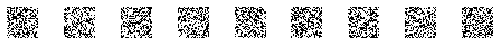

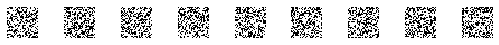

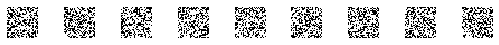

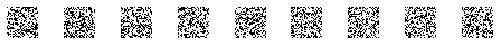

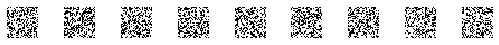

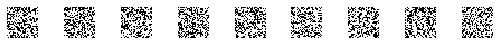

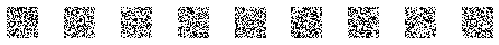

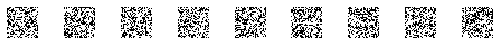

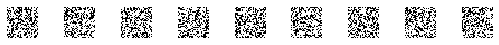

In [ ]:
from IPython.display import Image, display
from tqdm import tqdm_notebook

# Create an empty array of pixels.
batch = 81
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm_notebook(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tensorflow.math.ceil(
                probs - tensorflow.random.uniform(probs.shape)
            )

counter = 0
for i in range(9):
    plt.figure(figsize=(9,6))
    for j in range(9):
        plt.subplot(990 + 1 + j)
        plt.imshow(pixels[counter,:,:,0], cmap='gray_r')
        counter += 1
        plt.axis('off')
    plt.show()